### Building a Multilayer Perceptron (MLP) for Multi-category Classification

In this assignment, we will be build a multi layer neural network and train it to classify hand-written digits into 10 classes (digits 0-9).
We will use the [MNIST dataset of handwritten digits](http://yann.lecun.com/exdb/mnist/) for training the classifier. The dataset is a good example of real-world data and is popular in the Machine Learning community. 

In [1]:
#import libraries and functions to load the data
from digits import get_mnist
from matplotlib import pyplot as plt
import numpy as np
import ast
import sys
import numpy.testing as npt
import pytest
import random

#### STEP0. Load And Visualize Data

The MNIST dataset contains grayscale samples of handwritten digits of size 28 $\times$ 28. It is split into training set of 60,000 examples, and a test set of 10,000 examples.

In [2]:
random.seed(1)
np.random.seed(1)
trX, trY, tsX, tsY = get_mnist()
print('trX.shape: ', trX.shape)
print('trY.shape: ', trY.shape)
print('tsX.shape: ', tsX.shape)
print('tsY.shape: ', tsY.shape)

trX.shape:  (60000, 1, 28, 28)
trY.shape:  (60000,)
tsX.shape:  (10000, 1, 28, 28)
tsY.shape:  (10000,)


trX.shape:  (784, 2000)
trY.shape:  (1, 2000)
tsX.shape:  (784, 1000)
tsY.shape:  (1, 1000)
Train max: value = 1.0, Train min: value = -1.0
Test max: value = 1.0, Test min: value = -1.0
Unique labels in train:  [0 1 2 3 4 5 6 7 8 9]
Unique labels in test:  [0 1 2 3 4 5 6 7 8 9]

Displaying a few samples
labels
[[0 9 0 5 0 7 0 0 5 6]
 [0 5 4 4 6 7 3 0 9 7]
 [8 8 8 7 6 2 2 1 9 6]
 [8 1 7 2 0 3 5 2 7 6]
 [1 0 6 3 8 0 4 1 5 5]
 [9 1 3 1 8 2 7 5 1 6]
 [1 1 7 8 7 4 4 1 3 4]
 [7 7 8 1 8 6 4 4 2 8]
 [5 8 9 6 7 4 1 7 5 1]
 [0 6 5 8 6 9 8 4 1 5]]


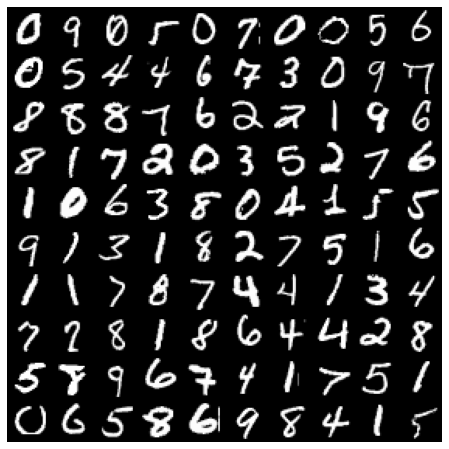

In [3]:
# The data is of the format (no_samples, channels, img_height, img_width)
# In the training data trX, there are 60000 images. Each image has one channel (gray scale). 
# Each image is of height=28 and width=28 pixels
# Lets sample a smaller subest to work with. 
# We will use 2000 training examples and 1000 test samples. 
# We define a function which we can use later as well 

def sample_mnist(n_train=2000, n_test=1000):
    trX, trY, tsX, tsY = get_mnist()
    random.seed(1)
    np.random.seed(1)
    tr_idx = np.random.choice(trX.shape[0], n_train)
    trX = trX[tr_idx]
    trY = trY[tr_idx]
    ts_idx = np.random.choice(tsX.shape[0], n_test)
    tsX = tsX[ts_idx]
    tsY = tsY[ts_idx]
    trX = trX.reshape(-1, 28*28).T
    trY = trY.reshape(1, -1)
    tsX = tsX.reshape(-1, 28*28).T
    tsY = tsY.reshape(1, -1)
    return trX, trY, tsX, tsY

# Lets verify the function
trX, trY, tsX, tsY = sample_mnist(n_train=2000, n_test=1000)
# Lets examine the data and see if it is normalized
print('trX.shape: ', trX.shape)
print('trY.shape: ', trY.shape)
print('tsX.shape: ', tsX.shape)
print('tsY.shape: ', tsY.shape)
print('Train max: value = {}, Train min: value = {}'.format(np.max(trX), np.min(trX)))
print('Test max: value = {}, Test min: value = {}'.format(np.max(tsX), np.min(tsX)))
print('Unique labels in train: ', np.unique(trY))
print('Unique labels in test: ', np.unique(tsY))

# Let's visualize a few samples and their labels from the train and test datasets.
print('\nDisplaying a few samples')
visx = np.concatenate((trX[:,:50],tsX[:,:50]), axis=1).reshape(28,28,10,10).transpose(2,0,3,1).reshape(28*10,-1)
visy = np.concatenate((trY[:,:50],tsY[:,:50]), axis=1).reshape(10,-1)
print('labels')
print(visy)
plt.figure(figsize = (8,8))
plt.axis('off')
plt.imshow(visx, cmap='gray');

#### STEP1. Defining Activation And Loss Functions Along With Their Derivatives

An Activation function usually adds nonlinearity to the output of a network layer using a mathematical operation. We will use two types of activation function in this assignment,

Rectified Linear Unit or ReLU
Linear activation (This is a dummy activation function without any nonlinearity implemented for convenience)

#### ReLU (Rectified Linear Unit)

ReLU (Rectified Linear Unit) is a piecewise linear function defined as
\begin{equation*}
ReLU(x) = \text{max}(0,x)
\end{equation*}


In [4]:
def relu(Z):
    '''
    Computes relu activation of input Z
    
    Inputs: 
        Z: numpy.ndarray (n, m) which represent 'm' samples each of 'n' dimension
        
    Outputs: 
        A: where A = ReLU(Z) is a numpy.ndarray (n, m) representing 'm' samples each of 'n' dimension
        cache: a dictionary with {"Z", Z}
        
    '''
    cache = {}
    cache = {"Z": Z}
    A = np.maximum(0, cache["Z"])
    A = A.tolist()

    return A, cache

#### Defining the gradient of ReLU 

The gradient of ReLu($Z$) is 1 if $Z>0$ else it is 0.

In [5]:
def relu_der(dA, cache):
    '''
    Computes derivative of relu activation
    
    Inputs: 
        dA: derivative from the subsequent layer of dimension (n, m). 
            dA is multiplied elementwise with the gradient of ReLU
        cache: dictionary with {"Z", Z}, where Z was the input 
            to the activation layer during forward propagation
        
    Outputs: 
        dZ: the derivative of dimension (n,m). It is the elementwise 
            product of the derivative of ReLU and dA
        
    '''
    dZ = np.array(dA, copy=True)
    Z = cache["Z"]
    
    dZ[Z > 0] = 1
    dZ[Z <= 0] = 0

    dZ = np.multiply(dA,dZ)
    
    return dZ

#### Linear Activation and Linear Activation Derivative

There is no activation involved here. It is an identity function. 
\begin{equation*}
\text{Linear}(Z) = Z
\end{equation*}

In [6]:
def linear(Z):
    '''
    Computes linear activation of Z
    This function is implemented for completeness
        
    Inputs: 
        Z: numpy.ndarray (n, m) which represent 'm' samples each of 'n' dimension
        
    Outputs: 
        A: where A = Linear(Z) is a numpy.ndarray (n, m) representing 'm' samples each of 'n' dimension
        cache: a dictionary with {"Z", Z}   
    '''
    A = Z
    cache = {}
    cache["Z"] = Z
    return A, cache

In [7]:
def linear_der(dA, cache):
    '''
    Computes derivative of linear activation
    This function is implemented for completeness
    
    Inputs: 
        dA: derivative from the subsequent layer of dimension (n, m). 
            dA is multiplied elementwise with the gradient of Linear(.)
        cache: dictionary with {"Z", Z}, where Z was the input 
            to the activation layer during forward propagation
        
    Outputs: 
        dZ: the derivative of dimension (n,m). It is the elementwise 
            product of the derivative of Linear(.) and dA
    '''      
    dZ = np.array(dA, copy=True)
    return dZ

#### Defining the Loss Function: Softmax Activation and Cross-entropy Loss Function

The softmax activation is computed on the outputs from the last layer and the output label with the maximum probablity is predicted as class label. The softmax function can also be refered as normalized exponential function which takes a vector of $n$ real numbers as input, and normalizes it into a probability distribution consisting of $n$ probabilities proportional to the exponentials of the input numbers.

The input to the softmax function is the $(n \times m)$ matrix, $ Z = [ z^{(1)} , z^{(2)}, \ldots, z^{(m)} ] $, where $z^{(i)}$ is the $i^{th}$ sample of $n$ dimensions. We estimate the softmax for each of the samples $1$ to $m$. The softmax activation for sample $z^{(i)}$ is $a^{(i)} = \text{softmax}(z^{(i)})$, where the components of $a^{(i)}$ are,
\begin{equation}
a_k{(i)} = \frac{\text{exp}(z^{(i)}_k)}{\sum_{k = 1}^{n}\text{exp}(z^{(i)}_k)} \qquad \text{for} \quad 1\leq k\leq n
\end{equation}

The output of the softmax is $ A = [ a^{(1)} , a^{(2)} .... a^{(m)} ]$, where $a^{(i)} = [a^{(i)}_1,a^{(i)}_2, \ldots, a^{(i)}_n]^\top$.  In order to avoid floating point overflow, we subtract a constant from all the input components of $z^{(i)}$ before calculating the softmax. This constant is $z_{max}$, where, $z_{max} = \text{max}(z_1,z_2,...z_n)$. The activation is given by,

\begin{equation}
a_k{(i)} = \frac{\text{exp}(z^{(i)}_k- z_{max})}{\sum_{k = 1}^{n}\text{exp}(z^{(i)}_k - z_{max})} \qquad \text{for} \quad 1\leq k\leq n
\end{equation}

If the output of softmax is given by $A$ and the ground truth is given by $Y = [ y^{(1)} , y^{(2)}, \ldots, y^{(m)}]$, the cross entropy loss between the predictions $A$ and groundtruth labels $Y$ is given by,

\begin{equation}
Loss(A,Y) = - \frac{1}{m} \sum_{i=1}^m \sum_{k=1}^{n}I \{ y^i = k \} \text{log}a_k^i
\end{equation}


where $I$ is the identity function given by 

\begin{equation}
I\{\text{condition}\} = 1, \quad \text{if condition = True}\\
I\{\text{condition}\} = 0, \quad \text{if condition = False}\\
\end{equation}


In [8]:
def softmax_cross_entropy_loss(Z, Y=np.array([])):
    '''
    Computes the softmax activation of the inputs Z
    Estimates the cross entropy loss

    Inputs: 
        Z: numpy.ndarray (n, m)
        Y: numpy.ndarray (1, m) of labels
            when y=[] loss is set to []
    
    Outputs:
        A: numpy.ndarray (n, m) of softmax activations
        cache: a dictionary to store the activations which will be used later to estimate derivatives
        loss: cost of prediction
    '''
    A = np.exp(Z-np.max(Z, axis = 0))/np.sum(np.exp(Z-np.max(Z, axis = 0)), axis = 0)
    cache = {}
    cache["A"] = A

    if len(Y) == 0:
        loss = []
    else:
        loss = 1/Z.shape[1]*np.sum(-np.log(A[Y.astype(int),range(Z.shape[1])]))

    return A, cache, loss


#### Defining the Derivative of the Softmax Cross-entropy Loss

It is easier to directly estimate $dZ$ which is $\frac{dL}{dZ}$, where $Z$ is the input to the *softmax_cross_entropy_loss($Z$)* function. 

Let $Z$ be the $(n\times m)$ dimension input and $Y$ be the $(1,m)$ groundtruth labels. If $A$ is the $(n\times m)$ matrix of softmax activations of $Z$, the derivative $dZ$ is given by, 

\begin{equation}
dZ =\frac{1}{m} (A -\bar{Y})
\end{equation}

where, $\bar{Y}$ is the one-hot representation of $Y$. 

One-hot encoding is a binary representation of the discrete class labels. For example, let $y^{(i)}\in\{0,1,2\}$ for a 3-category problem. Assume there are $m=4$ data points. In this case $Z$ will be a $3 \times 4$ matrix. Let the categories of the 4 data points be $Y=[1,0,1,2]$. The one hot representation is given by, 
\begin{equation}
\bar{Y} = 
    \begin{bmatrix}
    0 ~ 1 ~ 0 ~ 0\\
    1 ~ 0 ~ 1 ~ 0\\
    0 ~ 0 ~ 0 ~ 1
    \end{bmatrix}
\end{equation}
where, the one-hot encoding for label $y^{(1)} = 1$ is $\bar{y}^{(1)} = [0, 1, 0]^\top$. Similarly, the one-hot encoding for $y^{(4)} = 2$ is $\bar{y}^{(4)} = [0, 0, 1]^\top$

In [9]:
def softmax_cross_entropy_loss_der(Y, cache):
    '''
    Computes the derivative of the softmax activation and cross entropy loss

    Inputs: 
        Y: numpy.ndarray (1, m) of labels
        cache: a dictionary with cached activations A of size (n,m)

    Outputs:
        dZ: derivative dL/dZ - a numpy.ndarray of dimensions (n, m) 
    '''
    A = cache["A"]
    # your code here
    dZ = A.copy()
    #one-hot rep
    dZ[Y.astype(int),range(Y.shape[1])] -= 1
    dZ = dZ/Y.shape[1]
    return dZ

#### STEP2. Defining The Parameter Initialization Function

Let us now define a function that can initialize the parameters of the multi-layer neural network.
The network parameters will be stored as dictionary elements that can easily be passed as function parameters while calculating gradients during back propogation.

1. The weight matrix is initialized with random values from a normal distribution with variance $1$. For example, to create a matrix $w$ of dimension $3 \times 4$, with values from a normal distribution with variance $1$, we write $w = 0.01*np.random.randn(3,4)$. The $0.01$ is to ensure very small values close to zero for faster training.

2. Bias values are initialized with 0. For example a bias vector of dimensions $3 \times 1$ is initialized as $b = np.zeros((3,4))$

The dimension for weight matrix for layer $(l+1)$ is given by ( Number-of-neurons-in-layer-$(l+1)$   $\times$   Number-of-neurons-in-layer-$l$ ). The dimension of the bias for for layer $(l+1)$ is (Number-of-neurons-in-layer-$(l+1)$   $\times$   1)

In [10]:
def initialize_network(net_dims):
    '''
    Initializes the parameters of a multi-layer neural network
    
    Inputs:
        net_dims: List containing the dimensions of the network. The values of the array represent the number of nodes in 
        each layer. For Example, if a Neural network contains 784 nodes in the input layer, 800 in the first hidden layer, 
        500 in the secound hidden layer and 10 in the output layer, then net_dims = [784,800,500,10]. 
    
    Outputs:
        parameters: Python Dictionary for storing the Weights and bias of each layer of the network
    '''
    numLayers = len(net_dims)
    parameters = {}
    for l in range(numLayers-1):
        # parameters["W"+str(l+1)] =
        parameters["W"+str(l+1)] = 0.01*np.random.randn(net_dims[l+1],net_dims[l])
        # parameters["b"+str(l+1)] =
        parameters["b"+str(l+1)] = np.zeros((net_dims[l+1],1))
        
    return parameters

#### STEP3. Forward Propagation

If the vectorized input to any layer of neural network is $A\_prev$ and the parameters of the layer is given by $(W,b)$, the output of the layer (before the activation is):
\begin{equation}
Z = W.A\_prev + b
\end{equation}


In [11]:
def linear_forward(A_prev, W, b):
    '''
    Input A_prev propagates through the layer 
    Z = WA + b is the output of this layer. 

    Inputs: 
        A_prev: numpy.ndarray (n,m) the input to the layer
        W: numpy.ndarray (n_out, n) the weights of the layer
        b: numpy.ndarray (n_out, 1) the bias of the layer

    Outputs:
        Z: where Z = W.A_prev + b, where Z is the numpy.ndarray (n_out, m) dimensions
        cache: a dictionary containing the inputs A
    '''
    Z = np.dot(W,A_prev) + b

    cache = {}
    cache["A"] = A_prev
    return Z, cache

#### Activation After Forward Propagation

The linear transformation in a layer is usually followed by a nonlinear activation function given by, 

\begin{equation}
Z = W.A\_prev + b\\
A = \sigma(Z).
\end{equation}

Depending on the activation choosen for the given layer, the $\sigma(.)$ can represent different operations.


In [12]:
def layer_forward(A_prev, W, b, activation):
    '''
    Input A_prev propagates through the layer and the activation

    Inputs: 
        A_prev: numpy.ndarray (n,m) the input to the layer
        W: numpy.ndarray (n_out, n) the weights of the layer
        b: numpy.ndarray (n_out, 1) the bias of the layer
        activation: is the string that specifies the activation function

    Outputs:
        A: = g(Z), where Z = WA + b, where Z is the numpy.ndarray (n_out, m) dimensions
        g is the activation function
        cache: a dictionary containing the cache from the linear and the nonlinear propagation
        to be used for derivative
    '''

    Z, lin_cache = linear_forward(A_prev, W, b)
    if activation == "relu":
        A, act_cache = relu(Z)
    elif activation == "linear":
        A, act_cache = linear(Z)

    cache = {}
    cache["lin_cache"] = lin_cache
    cache["act_cache"] = act_cache
    return A, cache

#### Multi-Layer Forward Propagation

Multiple layers are stacked to form a multi layer network. The number of layers in the network can be inferred from the size of the $parameters$ variable from *initialize_network()* function. If the number of items in the dictionary element $parameters$ is $2L$, then the number of layers will be $L$

During forward propagation, the input $A_0$ which is a $n \times m$ matrix of $m$ samples where each sample is $n$ dimensions, is input into the first layer. The subsequent layers use the activation output from the previous layer as inputs.

Note all the hidden layers in our network use **ReLU** activation except the last layer which uses **Linear** activation.


In [13]:
def multi_layer_forward(A0, parameters):
    '''
    Forward propgation through the layers of the network

    Inputs: 
        A0: numpy.ndarray (n,m) with n features and m samples
        parameters: dictionary of network parameters {"W1":[..],"b1":[..],"W2":[..],"b2":[..]...}
    
    Outputs:
        AL: numpy.ndarray (c,m)  - outputs of the last fully connected layer before softmax
            where c is number of categories and m is number of samples
        caches: a dictionary of associated caches of parameters and network inputs
    '''
    L = len(parameters)//2  
    A = A0
    caches = []
    
    for l in range(1,L):
        A, cache = layer_forward(A, parameters["W"+str(l)], parameters["b"+str(l)], "relu")
        caches.append(cache)
    
    AL, cache = layer_forward(A, parameters["W"+str(L)], parameters["b"+str(L)], "linear")
    caches.append(cache)
    return AL, caches

#### STEP4. Backward Propagagtion

Consider the linear layer $Z = W.A\_prev + b$. We would like to estimate the gradients $\frac{dL}{dW}$ - represented as $dW$, $\frac{dL}{db}$ - represented as $db$ and $\frac{dL}{dA\_prev}$ - represented as $dA\_prev$. 
The input to estimate these derivatives is $\frac{dL}{dZ}$ - represented as $dZ$. The derivatives are given by, 

\begin{equation}
dA\_prev = W^T dZ\\
dW = dZ A^T\\
db = \sum_{i=1}^{m} dZ^{(i)}\\
\end{equation}

where $dZ = [dz^{(1)},dz^{(2)}, \ldots, dz^{(m)}]$ is $(n \times m)$ matrix of derivatives. 
The figure below represents a case fo binary cassification where $dZ$ is of dimensions $(1 \times m)$. The example can be extended to $(n\times m)$. 


In [14]:
def linear_backward(dZ, cache, W, b):
    '''
    Backward prpagation through the linear layer

    Inputs:
        dZ: numpy.ndarray (n,m) derivative dL/dz 
        cache: a dictionary containing the inputs A, for the linear layer
            where Z = WA + b,    
            Z is (n,m); W is (n,p); A is (p,m); b is (n,1)
        W: numpy.ndarray (n,p)
        b: numpy.ndarray (n, 1)

    Outputs:
        dA_prev: numpy.ndarray (p,m) the derivative to the previous layer
        dW: numpy.ndarray (n,p) the gradient of W 
        db: numpy.ndarray (n, 1) the gradient of b
    '''
    A = cache["A"]
    A = np.array(A)
    dW = np.dot(dZ, A.T)
    db = np.sum(dZ,axis=1, keepdims=True)
    dA_prev = np.dot(W.T,dZ)
    return dA_prev, dW, db

#### Back Propagation With Activation 

We will define the backpropagation for a layer. We will use the backpropagation for a linear layer along with the derivative for the activation. 

In [15]:
def layer_backward(dA, cache, W, b, activation):
    '''
    Backward propagation through the activation and linear layer

    Inputs:
        dA: numpy.ndarray (n,m) the derivative to the previous layer
        cache: dictionary containing the linear_cache and the activation_cache
        activation - activation of the layer
        W: numpy.ndarray (n,p)
        b: numpy.ndarray (n, 1)
    
    Outputs:
        dA_prev: numpy.ndarray (p,m) the derivative to the previous layer
        dW: numpy.ndarray (n,p) the gradient of W 
        db: numpy.ndarray (n, 1) the gradient of b
    '''

    lin_cache = cache["lin_cache"]
    act_cache = cache["act_cache"]

    if activation == "relu":
        dZ = relu_der(dA, act_cache)
    elif activation == "linear":
        dZ = linear_der(dA, act_cache)
    dA_prev, dW, db = linear_backward(dZ, lin_cache, W, b)
    return dA_prev, dW, db

#### Multi-layer Back Propagation

We have defined the required functions to handle back propagation for single layer. Now we will stack the layers together and perform back propagation on the entire network.

In [16]:
def multi_layer_backward(dAL, caches, parameters):
    '''
    Back propgation through the layers of the network (except softmax cross entropy)
    softmax_cross_entropy can be handled separately

    Inputs: 
        dAL: numpy.ndarray (n,m) derivatives from the softmax_cross_entropy layer
        caches: a dictionary of associated caches of parameters and network inputs
        parameters - dictionary of network parameters {"W1":[..],"b1":[..],"W2":[..],"b2":[..]...}

    Outputs:
        gradients: dictionary of gradient of network parameters 
            {"dW1":[..],"db1":[..],"dW2":[..],"db2":[..],...}
    '''

    L = len(caches) 
    gradients = {}
    dA = dAL
    activation = "linear"
    for l in reversed(range(1,L+1)):
        dA, gradients["dW"+str(l)], gradients["db"+str(l)] = \
                    layer_backward(dA, caches[l-1], \
                    parameters["W"+str(l)],parameters["b"+str(l)],\
                    activation)
        activation = "relu"
    return gradients

#### STEP5. Defining The Prediction Function

We will perform forward propagation through the entire network and determine the class predictions for the input data

In [17]:
def classify(X, parameters):
    '''
    Network prediction for inputs X

    Inputs: 
        X: numpy.ndarray (n,m) with n features and m samples
        parameters: dictionary of network parameters 
            {"W1":[..],"b1":[..],"W2":[..],"b2":[..],...}
    Outputs:
        YPred: numpy.ndarray (1,m) of predictions
    '''
    # Using 'softmax_cross_entropy loss(.)', obtain softmax activation 'AL' with input 'A' from step 1
    # Predict class label 'YPred' as the 'argmax' of softmax activation from step-2. 
    # Note: the shape of 'YPred' is (1,m), where m is the number of samples
    
    # Forward propagate input 'X' using multi_layer_forward(.) and obtain the final activation 'A'
    A, caches = multi_layer_forward(X, parameters)
    
    AL,cache,loss = softmax_cross_entropy_loss(A)
    YPred = np.argmax(AL,axis = 0)
    YPred =np.reshape(YPred, (1,YPred.size))
    
    return YPred

#### STEP6. Parameter Update Using Batch-Gradient

The parameter gradients $(dW,db)$ calculated during back propagation are used to update the values of the network parameters.

\begin{equation}
W := W - \alpha.dW\\
b := b - \alpha.db,
\end{equation}

where $\alpha$ is the learning rate of the network. 

In [18]:
def update_parameters(parameters, gradients, epoch, alpha):
    '''
    Updates the network parameters with gradient descent

    Inputs:
        parameters: dictionary of network parameters 
            {"W1":[..],"b1":[..],"W2":[..],"b2":[..],...}
        gradients: dictionary of gradient of network parameters 
            {"dW1":[..],"db1":[..],"dW2":[..],"db2":[..],...}
        epoch: epoch number
        alpha: step size or learning rate
        
    Outputs:
        parameters: updated dictionary of network parameters 
            {"W1":[..],"b1":[..],"W2":[..],"b2":[..],...}
    '''
    
    L = len(parameters)//2
    for i in range(L):
        parameters["W"+str(i+1)] = parameters["W"+str(i+1)] - alpha*gradients["dW"+str(i+1)]
        parameters["b"+str(i+1)] = parameters["b"+str(i+1)] - alpha*gradients["db"+str(i+1)]
        # your code here
        
    return parameters

#### STEP7. Designing the Neural Network 

Let us now assemble all the components of the neural network together and define a complete training loop for a Multi-layer Neural Network.

In [19]:
def multi_layer_network(X, Y, net_dims, num_iterations=500, learning_rate=0.1, log=True):
    
    '''
    Creates the multilayer network and trains the network

    Inputs:
        X: numpy.ndarray (n,m) of training data
        Y: numpy.ndarray (1,m) of training data labels
        net_dims: tuple of layer dimensions
        num_iterations: num of epochs to train
        learning_rate: step size for gradient descent
        log: boolean to print training progression 
    
    Outputs:
        costs: list of costs (or loss) over training
        parameters: dictionary of trained network parameters
    '''

    parameters = initialize_network(net_dims)
    A0 = X
    costs = []
    num_classes = 10
    alpha = learning_rate
    for ii in range(num_iterations):
        
        ## Forward Propagation
        # Step 1: Input 'A0' and 'parameters' into the network using multi_layer_forward()
        # and calculate output of last layer 'A' (before softmax) and obtain cached activations as 'caches'
        A, caches = multi_layer_forward(A0, parameters)
        # Step 2: Input 'A' and groundtruth labels 'Y' to softmax_cros_entropy_loss(.) and estimate
        # activations 'AL', 'softmax_cache' and 'loss'
        AL, softmax_cache, cost = softmax_cross_entropy_loss(A,Y)
        
        ## Back Propagation
        # Step 3: Estimate gradient 'dAL' with softmax_cross_entropy_loss_der(.) using groundtruth 
        # labels 'Y' and 'softmax_cache'
        dAL = softmax_cross_entropy_loss_der(Y, softmax_cache)
        # Step 4: Estimate 'gradients' with multi_layer_backward(.) using 'dAL' and 'parameters' 
        gradients = multi_layer_backward(dAL,caches,parameters)
        # Step 5: Estimate updated 'parameters' and updated learning rate 'alpha' with update_parameters(.) 
        #         using 'parameters', 'gradients', loop variable 'ii' (epoch number) and 'learning_rate'
        #         Note: Use the same variable 'parameters' as input and output to the update_parameters(.) function
        
        parameters = update_parameters(parameters, gradients, ii, learning_rate) 
        
        if ii % 20 == 0:
            costs.append(cost)
            if log:
                print("Cost at iteration %i is: %.05f, learning rate: %.05f" %(ii+1, cost, learning_rate))
    
    return costs, parameters

#### STEP8. Training

We will now intialize a neural network with 1 hidden layer whose dimensions is 200. 
Since the input samples are of dimension 28 $\times$ 28, the input layer will be of dimension 784. The output dimension is 10 since we have a 10 category classification. 
We will train the model and compute its accuracy on both training and test sets and plot the training cost (or loss) against the number of iterations. 

Network dimensions are:[784, 200, 10]
Cost at iteration 1 is: 2.30316, learning rate: 0.10000
Cost at iteration 21 is: 1.76942, learning rate: 0.10000
Cost at iteration 41 is: 1.27439, learning rate: 0.10000
Cost at iteration 61 is: 0.68772, learning rate: 0.10000
Cost at iteration 81 is: 0.70823, learning rate: 0.10000
Cost at iteration 101 is: 0.50654, learning rate: 0.10000
Cost at iteration 121 is: 0.45776, learning rate: 0.10000
Cost at iteration 141 is: 0.39762, learning rate: 0.10000
Cost at iteration 161 is: 0.35908, learning rate: 0.10000
Cost at iteration 181 is: 0.33940, learning rate: 0.10000
Cost at iteration 201 is: 0.30880, learning rate: 0.10000
Cost at iteration 221 is: 0.29273, learning rate: 0.10000
Cost at iteration 241 is: 0.27032, learning rate: 0.10000
Cost at iteration 261 is: 0.25874, learning rate: 0.10000
Cost at iteration 281 is: 0.23687, learning rate: 0.10000
Cost at iteration 301 is: 0.22448, learning rate: 0.10000
Cost at iteration 321 is: 0.23108, learn

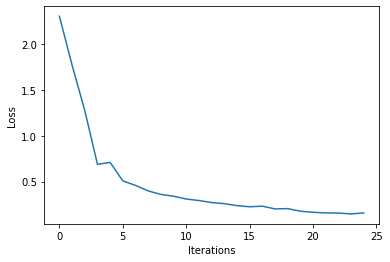

In [20]:
net_dims = [784,200,10] 
#784 is for image dimensions
#10 is for number of categories 
#200 is arbitrary

# initialize learning rate and num_iterations 
learning_rate = 0.1
num_iterations = 500

np.random.seed(1)
print("Network dimensions are:" + str(net_dims))

# getting the subset dataset from MNIST
trX, trY, tsX, tsY = sample_mnist(n_train=2000, n_test=1000)

costs, parameters = multi_layer_network(trX, trY, net_dims, \
        num_iterations=num_iterations, learning_rate=learning_rate)

# compute the accuracy for training set and testing set
train_Pred = classify(trX, parameters)

test_Pred = classify(tsX, parameters)

#Estimate the training accuracy 'trAcc' and the testing accuracy 'teAcc'
# your code here
trAcc = np.mean(train_Pred == trY)*100

teAcc = np.mean(test_Pred == tsY)*100


print("Accuracy for training set is {0:0.3f} %".format(trAcc))
print("Accuracy for testing set is {0:0.3f} %".format(teAcc))

plt.plot(costs)
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.show()